# Predicting Orange Futures Prices Based on Weather

## CDS Algo Project S21

### Authors: Alex Lin, Brian Bobby, Divya Damodaran, Liam Bodurtha

### TODO for next week (updated 3/27)
- make table of production by county from map (https://www.nass.usda.gov/Statistics_by_State/Florida/Publications/Citrus/Citrus_Statistics/2015-16/fcs1516.pdf)
- Liam and Divya meeting this week to filter/clean data
    - talk about how to replace -99.00 values
    - decide on starting date
    - maybe make one massive dataframe
- Brian and Alex continue to research methodology and come up with concrete options for analysis

In [47]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from datetime import date
import finplot as fplt
import requests
import pandas as pd
import numpy as np
import io
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns

In [2]:
r = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ1.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data = pd.read_csv(io.StringIO(r.text))

In [3]:
counties = ['Hendry', 'DeSoto', 'Polk', 'Highlands', 'Hardee', 'St Lucie', 'Collier', 'Indian River', 'Manatee', 'Charlotte', 'Lee','Lake', 'Osceola', 'Glades', 'Okeechobee', 'Hillsborough', 'Pasco', 'Martin', 'Orange', 'Brevard', 'Sarasota', 'Marion', 'Volusia', 'Hernando', 'Seminole']
boxes = [14282, 12773, 12539, 9735, 8436, 6693, 6677, 5965, 3282, 2696, 2128, 1606, 1463, 1360, 152, 718, 687, 684, 351, 335, 212, 163, 111, 91, 43]
productionDf = pd.DataFrame({'County:': counties, 'Boxes Produced of Oranges(in 1000s)': boxes })
productionDf

,County:,Boxes Produced of Oranges(in 1000s)
0,Hendry,14282
1,DeSoto,12773
2,Polk,12539
3,Highlands,9735
4,Hardee,8436
5,St Lucie,6693
6,Collier,6677
7,Indian River,5965
8,Manatee,3282
9,Charlotte,2696


In [4]:
futures_data.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
0,2021-04-16,114.15,114.85,113.45,113.95,0.05,114.24,1145.0,5277.0,NaN,NaN,NaN
1,2021-04-15,111.35,114.20,111.00,113.90,2.90,113.09,1343.0,6214.0,NaN,NaN,NaN
2,2021-04-14,110.00,111.75,109.25,111.00,1.00,110.77,987.0,6781.0,20.0,NaN,NaN
3,2021-04-13,109.30,110.25,109.10,110.00,0.70,109.53,773.0,7307.0,20.0,NaN,NaN
4,2021-04-12,109.65,110.10,108.75,109.30,-0.75,109.30,552.0,7552.0,NaN,NaN,NaN


In [5]:
futures_data['Date'] = pd.to_datetime(futures_data['Date'])
futures_data.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
0,2021-04-16,114.15,114.85,113.45,113.95,0.05,114.24,1145.0,5277.0,NaN,NaN,NaN
1,2021-04-15,111.35,114.20,111.00,113.90,2.90,113.09,1343.0,6214.0,NaN,NaN,NaN
2,2021-04-14,110.00,111.75,109.25,111.00,1.00,110.77,987.0,6781.0,20.0,NaN,NaN
3,2021-04-13,109.30,110.25,109.10,110.00,0.70,109.53,773.0,7307.0,20.0,NaN,NaN
4,2021-04-12,109.65,110.10,108.75,109.30,-0.75,109.30,552.0,7552.0,NaN,NaN,NaN


In [6]:
futures_data.dtypes

Date                       datetime64[ns]
Open                              float64
High                              float64
Low                               float64
Settle                            float64
Change                            float64
Wave                              float64
Volume                            float64
Prev. Day Open Interest           float64
EFP Volume                        float64
EFS Volume                        float64
Block Volume                      float64
dtype: object

In [7]:
station_county = pd.read_csv('station_county_matching.csv')

In [8]:
station_county

,Station,County
0,APALACHICOLA AP,Franklin
1,ARCADIA,Desoto
2,ARCHBOLD BIO STN,Highlands
3,AVON PARK 2 W,Highlands
4,BARTOW,Polk
...,...,...
85,VERO BEACH 4SE,Indian River
86,WAUCHULA,Hardee
87,WEEKI WACHEE,Hernando
88,WEST PALM BEACH INTL AP,Palm Beach


In [9]:
weather_station_dfs = {}
for station in station_county['Station']:
    dfname = station.lower().replace(' ','_')
    weather_station_dfs[dfname] = pd.read_csv('orangeCsvs/'+station+'.csv')

In [10]:
weather_station_dfs['arcadia'].head()

,Unnamed: 0,id,year,month,day,precipitation,maxTemp,minTemp,meanTemp
0,0,80228,1899,1,1,-99.99,-99.9,-99.9,-99.90000
1,1,80228,1899,1,2,-99.99,-99.9,-99.9,-99.90000
2,2,80228,1899,1,3,-99.99,-99.9,-99.9,-99.90000
3,3,80228,1899,1,4,-99.99,-99.9,-99.9,-99.90000
4,4,80228,1899,1,5,-99.99,-99.9,-99.9,-99.90000


In [11]:
station_county[station_county['County'] == 'Collier']

,Station,County
37,IMMOKALEE,Collier
58,NAPLES,Collier
60,OASIS RS,Collier


In [12]:
stations_in_citrus_regions = []
for s in range(len(station_county.iloc[:,1].copy())):
    for c in counties:
        if c.lower().replace('saint', 'st') == station_county.iloc[s,1].lower():
              stations_in_citrus_regions.append(station_county.iloc[s,0].lower().replace(' ', '_'))
stations_in_citrus_regions.append('ft_pierce')
 #zero non-null rows - 3 more weather stations available for county 
print(stations_in_citrus_regions)

['arcadia', 'archbold_bio_stn', 'avon_park_2_w', 'bartow', 'bradenton_5_ese', 'brooksville_chin_hill', 'clermont_9_s', 'daytona_beach', 'daytona_beach_intl_ap', 'deland_1_sse', 'desoto_city_8_sw', 'devils_garden', 'fort_drum', 'ft_green_12_wsw', 'ft_myers_page_fld_ap', 'ft_pierce', 'hillsborough_river_sp', 'immokalee', 'kissimmee_2', 'la_belle', 'lisbon', 'melbourne_intl_ap', 'moore_haven_lock_1', 'mtn_lake', 'myakka_river_sp', 'naples', 'oasis_rs', 'ocala', 'okeechobee', 'orlando_intl_ap', 'parrish', 'plant_city', 'punta_gorda_4_ese', 'saint_leo', 'sanford', 'stuart', 'tampa_intl_ap', 'titusville', 'venice', 'vero_beach_intl_ap', 'vero_beach_4se', 'wauchula', 'weeki_wachee', 'ft_pierce']


In [13]:
# fil_weather_station_dfs contains the stations from counties that produce oranges
fil_weather_station_dfs = (weather_station_dfs.fromkeys(stations_in_citrus_regions))

for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station] = weather_station_dfs[station].copy() 

Dropping:
* before start date of futures data (maybe 1967, feb2)
* replace -99.00's with NaN
* ~2 weather stations start at 1978 or later, a few more start between 1967 and 1978, so we should discuss trimming everything to 1978 and 

In [14]:
for dfname in stations_in_citrus_regions:
    fil_weather_station_dfs[dfname] = fil_weather_station_dfs[dfname][fil_weather_station_dfs[dfname]['year'] >= 1967]
    

In [15]:
print(len(fil_weather_station_dfs['oasis_rs']))
fil_weather_station_dfs['oasis_rs'].isnull().sum(axis = 0)

14637


Unnamed: 0       0
id               0
year             0
month            0
day              0
precipitation    0
maxTemp          0
minTemp          0
meanTemp         0
dtype: int64

In [18]:
#Making columns float types and dropping bad column
for station in stations_in_citrus_regions:
    df = fil_weather_station_dfs[station].copy()
    df['precipitation'] = df['precipitation'].astype(float)
    
    df['meanTemp'] = df['meanTemp'].replace(' ','-99.9')
    df['meanTemp'] = df['meanTemp'].astype('float64')
    
    #df = df.drop(columns = 'Unnamed: 0')
    
    fil_weather_station_dfs[station] = df

In [19]:
fil_weather_station_dfs['arcadia']

,id,year,month,day,precipitation,maxTemp,minTemp,meanTemp
24888,80228,1967,1,1,0.00,81.0,56.0,68.5
24889,80228,1967,1,2,0.00,85.0,65.0,75.0
24890,80228,1967,1,3,0.07,84.0,67.0,75.5
24891,80228,1967,1,4,0.14,77.0,60.0,68.5
24892,80228,1967,1,5,0.00,66.0,32.0,49.0
...,...,...,...,...,...,...,...,...
43546,80228,2017,12,27,0.00,79.0,55.0,67.0
43547,80228,2017,12,28,0.00,81.0,56.0,68.5
43548,80228,2017,12,29,0.00,78.0,56.0,67.0
43549,80228,2017,12,30,0.01,-99.9,50.0,-99.9


In [20]:
#replacing -99..9 with Nan
for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station]['meanTemp'] = fil_weather_station_dfs[station]['meanTemp'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['precipitation'] = fil_weather_station_dfs[station]['precipitation'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['maxTemp'] = fil_weather_station_dfs[station]['maxTemp'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['minTemp'] = fil_weather_station_dfs[station]['minTemp'].replace(-99.9, np.nan)


In [21]:
for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station] = fil_weather_station_dfs[station].dropna()

In [22]:
#Dataframes that are only from counties that produce oranges with all year >= 1967 and rows with NaNs dropped
#we still have lots of data
fil_weather_station_dfs['arcadia'].isnull().sum(axis = 0)

id               0
year             0
month            0
day              0
precipitation    0
maxTemp          0
minTemp          0
meanTemp         0
dtype: int64

In [23]:
#1970 - immokalee, 2010 - melbourne_intl_ap
for station in fil_weather_station_dfs.keys():
    print(station + ": " + str(len(fil_weather_station_dfs[station]['year'])))

arcadia: 17193
archbold_bio_stn: 17102
avon_park_2_w: 16668
bartow: 17317
bradenton_5_ese: 17267
brooksville_chin_hill: 15779
clermont_9_s: 17461
daytona_beach: 5005
daytona_beach_intl_ap: 17896
deland_1_sse: 16876
desoto_city_8_sw: 0
devils_garden: 15617
fort_drum: 13344
ft_green_12_wsw: 4862
ft_myers_page_fld_ap: 16994
ft_pierce: 17790
hillsborough_river_sp: 54
immokalee: 14594
kissimmee_2: 17107
la_belle: 14027
lisbon: 17552
melbourne_intl_ap: 2008
moore_haven_lock_1: 17760
mtn_lake: 17559
myakka_river_sp: 16715
naples: 17574
oasis_rs: 13227
ocala: 17675
okeechobee: 13338
orlando_intl_ap: 16736
parrish: 16696
plant_city: 17315
punta_gorda_4_ese: 17631
saint_leo: 17697
sanford: 17756
stuart: 16168
tampa_intl_ap: 17897
titusville: 16890
venice: 16311
vero_beach_intl_ap: 11686
vero_beach_4se: 17503
wauchula: 17417
weeki_wachee: 15215


In [24]:
for station in fil_weather_station_dfs.keys():
    if not station == 'desoto_city_8_sw':
        print(station + ": " + str(fil_weather_station_dfs[station]['year'].iloc[0]))

arcadia: 1967
archbold_bio_stn: 1969
avon_park_2_w: 1967
bartow: 1967
bradenton_5_ese: 1967
brooksville_chin_hill: 1967
clermont_9_s: 1967
daytona_beach: 2000
daytona_beach_intl_ap: 1967
deland_1_sse: 1967
devils_garden: 1967
fort_drum: 1967
ft_green_12_wsw: 2001
ft_myers_page_fld_ap: 1967
ft_pierce: 1967
hillsborough_river_sp: 1967
immokalee: 1970
kissimmee_2: 1967
la_belle: 1967
lisbon: 1967
melbourne_intl_ap: 2010
moore_haven_lock_1: 1967
mtn_lake: 1967
myakka_river_sp: 1968
naples: 1967
oasis_rs: 1978
ocala: 1967
okeechobee: 1967
orlando_intl_ap: 1967
parrish: 1967
plant_city: 1967
punta_gorda_4_ese: 1967
saint_leo: 1967
sanford: 1967
stuart: 1967
tampa_intl_ap: 1967
titusville: 1967
venice: 1967
vero_beach_intl_ap: 1984
vero_beach_4se: 1967
wauchula: 1967
weeki_wachee: 1969


In [25]:
#Try merging the station results for each county for each county. If a row is Nan in one station ignore and average witht the other 

In [27]:
station_county['Station'] = station_county['Station'].apply(lambda x: x.lower().replace(' ', '_'))
station_county['County'] = station_county['County'].apply(lambda x: x.lower().replace('saint', 'st'))

county_dfs = {}

for county in counties:
    if county == "St. Lucie":
        county = "St Lucie"
        
    county = county.lower()
    df = pd.DataFrame()
    
    for stat in station_county[station_county['County'] == county]['Station']:
        if stat in fil_weather_station_dfs.keys():
            
            temp_df = fil_weather_station_dfs[stat].copy()
            temp_df['County'] = county
        
            df = df.append(temp_df)
    
    county_dfs[county] = df


In [29]:
productionDf['County:'] = productionDf['County:'].apply(lambda x: x.lower().replace('st.', 'st'))

In [30]:
total_boxes = 0
for coun in county_dfs.keys():
    mult = int(productionDf[productionDf['County:'] == coun]['Boxes Produced of Oranges(in 1000s)'])
    total_boxes += mult
    county_dfs[coun] = (county_dfs[coun].groupby(['year', 'month', 'day']).mean())
    df = county_dfs[coun]
    df['minTemp'] = df['minTemp']*mult
    df['maxTemp'] = df['maxTemp']*mult
    df['meanTemp'] = df['meanTemp']*mult
    df['precipitation'] = df['precipitation']*mult

    df['weight'] = mult
    county_dfs[coun] = df
    print(len(df))

17191
17193
17866
17816
17534
17790
17890
17877
17824
17631
16994
17890
17107
17760
15788
17897
17697
16168
16736
17004
17761
17675
17897
17027
17756


In [31]:
len(county_dfs.keys())

25

In [32]:
final_df = pd.DataFrame()
for county in county_dfs.keys():
    final_df = final_df.append(county_dfs[county])
    
final_df = final_df.groupby(['year', 'month', 'day']).sum()


In [33]:
print(final_df)

                       id  precipitation    maxTemp    minTemp    meanTemp  \
year month day                                                               
1967 1     1    2046299.5          0.000  7630978.0  5356702.0  6493840.00   
           2    2046299.5        164.010  7791664.5  5962311.0  6876987.75   
           3    2046299.5       5021.840  7838329.0  6137728.5  6988028.75   
           4    1961674.5      25021.380  7084575.0  5353286.0  6218930.50   
           5    2046299.5       4167.660  5982874.0  3467413.5  4725143.75   
...                   ...            ...        ...        ...         ...   
2017 12    27   1963113.0          0.000  7313722.0  5217165.5  6265443.75   
           28   1963088.0          0.555  7460119.5  5385999.0  6423059.25   
           29   1963088.0         60.035  7101182.0  5244295.0  6172738.50   
           30   1882885.0          1.630  5640480.0  4135126.0  4887803.00   
           31   1794903.0          0.000  5590215.0  3580291.5  

In [34]:
weighted_df = final_df.copy()
weighted_df['minTemp'] = weighted_df['minTemp']/weighted_df['weight']
weighted_df['maxTemp'] = weighted_df['maxTemp']/weighted_df['weight']
weighted_df['meanTemp'] = weighted_df['meanTemp']/weighted_df['weight']
weighted_df['precipitation'] = weighted_df['precipitation']/weighted_df['weight']

In [35]:
weighted_df['weight'] = weighted_df['weight']/total_boxes

In [36]:
weighted_df = weighted_df.reset_index().drop(columns = 'id')
weighted_df

,year,month,day,precipitation,maxTemp,minTemp,meanTemp,weight
0,1967,1,1,0.000000,82.188741,57.693862,69.941301,0.996405
1,1967,1,2,0.001766,83.919400,64.216517,74.067959,0.996405
2,1967,1,3,0.054087,84.421995,66.105835,75.263915,0.996405
3,1967,1,4,0.273805,77.525333,58.580123,68.052728,0.980704
4,1967,1,5,0.044887,64.437989,37.345455,50.891722,0.996405
...,...,...,...,...,...,...,...,...
17892,2017,12,27,0.000000,78.693788,56.135374,67.414581,0.997392
17893,2017,12,28,0.000006,80.268988,57.951979,69.110484,0.997392
17894,2017,12,29,0.000646,76.406912,56.427280,66.417096,0.997392
17895,2017,12,30,0.000020,70.360003,51.582042,60.971023,0.860316


In [37]:
weighted_df['Date'] = pd.to_datetime(weighted_df[['year', 'month', 'day']])
weighted_df = weighted_df.drop(columns = ['year', 'month', 'day'])
weighted_df.head()

,precipitation,maxTemp,minTemp,meanTemp,weight,Date
0,0.000000,82.188741,57.693862,69.941301,0.996405,1967-01-01
1,0.001766,83.919400,64.216517,74.067959,0.996405,1967-01-02
2,0.054087,84.421995,66.105835,75.263915,0.996405,1967-01-03
3,0.273805,77.525333,58.580123,68.052728,0.980704,1967-01-04
4,0.044887,64.437989,37.345455,50.891722,0.996405,1967-01-05


In [38]:
weighted_df.dtypes

precipitation           float64
maxTemp                 float64
minTemp                 float64
meanTemp                float64
weight                  float64
Date             datetime64[ns]
dtype: object

In [39]:
futures_and_weather_df = pd.merge(futures_data, weighted_df, how="inner", on="Date")
futures_and_weather_df.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume,precipitation,maxTemp,minTemp,meanTemp,weight
0,2017-12-29,134.50,136.35,131.80,136.00,-0.70,133.46,132.0,409.0,NaN,NaN,NaN,0.000646,76.406912,56.427280,66.417096,0.997392
1,2017-12-28,132.25,137.50,131.15,136.70,3.55,135.01,285.0,623.0,NaN,NaN,NaN,0.000006,80.268988,57.951979,69.110484,0.997392
2,2017-12-27,133.50,134.80,131.15,133.15,-0.90,132.77,265.0,827.0,52.0,NaN,NaN,0.000000,78.693788,56.135374,67.414581,0.997392
3,2017-12-26,135.25,135.25,132.65,134.05,NaN,133.75,232.0,994.0,NaN,NaN,NaN,0.000000,77.516503,54.505437,66.010970,0.788489
4,2017-12-22,137.95,138.05,134.35,135.25,-1.80,135.15,322.0,1177.0,NaN,NaN,NaN,0.003400,81.792918,61.542716,71.667817,0.997392


In [40]:
futures_and_weather_df = futures_and_weather_df[['Date', 'Settle', 'precipitation', 'minTemp', 'meanTemp', 'weight']]
futures_and_weather_df

,Date,Settle,precipitation,minTemp,meanTemp,weight
0,2017-12-29,136.00,0.000646,56.427280,66.417096,0.997392
1,2017-12-28,136.70,0.000006,57.951979,69.110484,0.997392
2,2017-12-27,133.15,0.000000,56.135374,67.414581,0.997392
3,2017-12-26,134.05,0.000000,54.505437,66.010970,0.788489
4,2017-12-22,135.25,0.003400,61.542716,71.667817,0.997392
...,...,...,...,...,...,...
11737,1967-02-07,35.30,0.242868,59.301464,68.564827,1.000000
11738,1967-02-06,35.10,0.000000,45.716603,62.804781,1.000000
11739,1967-02-03,35.20,0.000000,54.947298,68.319011,1.000000
11740,1967-02-02,35.35,0.000000,50.599991,65.906086,1.000000


## Model Training Starts Here

In [ ]:
temp = weighted_df["meanTemp"]
rain = weighted_df["precipitation"]
price = futures_data["Settle"]

In [64]:
X = futures_and_weather_df[['minTemp']]
y = futures_and_weather_df['Settle']
linreg = LinearRegression().fit(X, y) #linear reg
#logreg = LogisticRegression().fit(x,y)
print('Coef: ' + str(linreg.coef_))
print("r^2 score: {:.2f}".format(linreg.score(X, y)))

Coef: [0.09297684]
r^2 score: 0.00


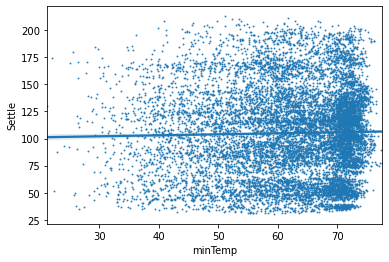

In [55]:
lin_regplot = sns.regplot(x="minTemp", y="Settle", data=futures_and_weather_df, scatter_kws={'s':1})

In [78]:
X = futures_and_weather_df[['precipitation']]
y = futures_and_weather_df['Settle']
linreg2 = LinearRegression().fit(X, y) #linear reg
#logreg = LogisticRegression().fit(x,y)
print('Coef: ' + str(linreg2.coef_))
print("r^2 score: {:.2f}".format(linreg2.score(X, y)))

Coef: [-1.77513919]
r^2 score: 0.01


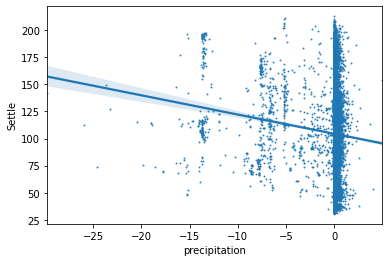

In [79]:
lin_regplot2 = sns.regplot(x="precipitation", y="Settle", data=futures_and_weather_df, scatter_kws={'s':1})

In [ ]:
#train_test_split on temp rain and price
#best if done on df contain all 3 the separating them into 3

In [ ]:
#Cross Validation:
#for i in range(5):